In [1]:
import numpy as np
import scipy
import poppy
if poppy.accel_math._USE_CUPY:
    import cupy as xp
    import cupyx.scipy as _scipy
else:
    xp = np
    _scipy = scipy
    
from poppy.poppy_core import PlaneType

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display

import zosapi
from System import Enum,Int32,Double,Array
from pathlib import Path

from importlib import reload

# import logging, sys
# poppy_log = logging.getLogger('poppy')
# poppy_log.setLevel('DEBUG')
# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

# poppy_log.disabled = True

# import warnings
# warnings.filterwarnings("ignore")

from prop_models import full, compact, agpm
reload(full)
reload(compact)
reload(agpm)

from wfsc_1dm import efc, pwp, utils

from imshows import imshow1, imshow2, imshow3

pupil_diam = 6.5*u.m
dm_diam = 10.2*u.mm
wavelength_c = 750e-9*u.m


# Generate pointing error samples

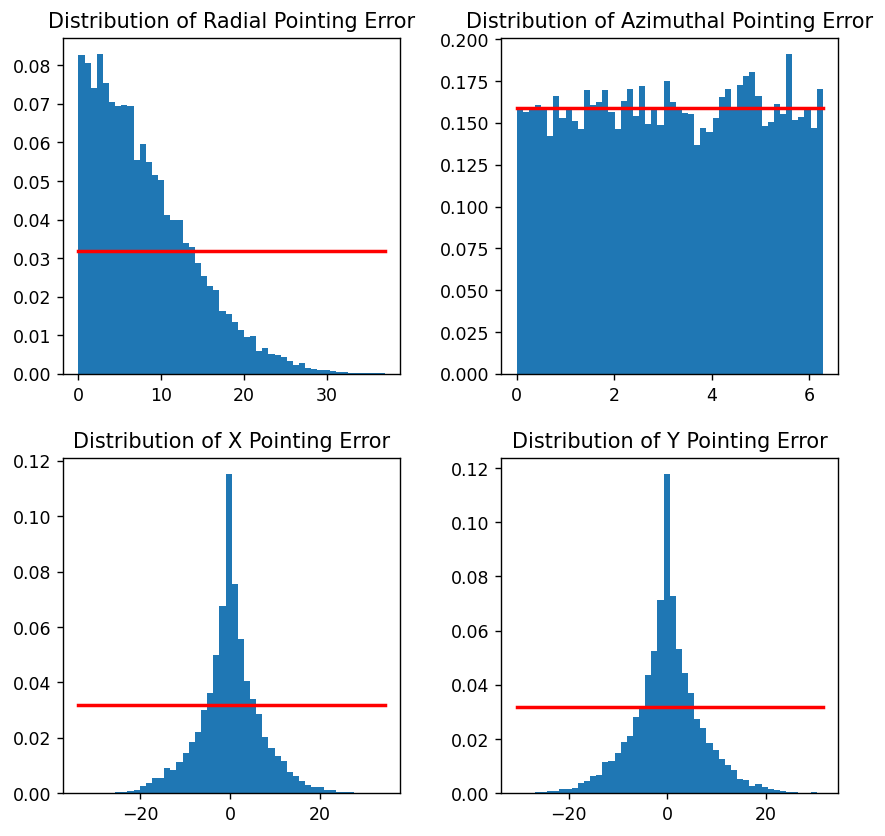

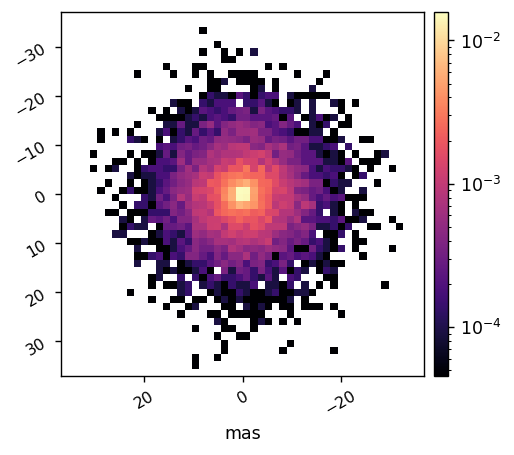

In [2]:
pointing_error = 10*u.mas # STD of pointing error
mean = 0

seed = 12

pointing_r = np.abs(np.random.default_rng(seed).normal(mean, pointing_error.to_value(u.mas), 10000))
pointing_th = np.random.default_rng(seed).uniform(low=0.0, high=2*np.pi, size=10000)

pointing_x = pointing_r*np.cos(pointing_th)
pointing_y = pointing_r*np.sin(pointing_th)

pointing = np.array([pointing_x, pointing_y]).T*u.mas

nbins = 50

fig = plt.figure(figsize=(8,8), dpi=125)

plt.subplot(221)
count, bins, ignored = plt.hist(pointing_r, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.title('Distribution of Radial Pointing Error')

plt.subplot(222)
count, bins, ignored = plt.hist(pointing_th, nbins, density=True)
plt.plot(bins, 1/(2*np.pi)*np.ones_like(bins), linewidth=2, color='r')
plt.title('Distribution of Azimuthal Pointing Error')

plt.subplot(223)
count, bins, ignored = plt.hist(pointing_x, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.title('Distribution of X Pointing Error')

plt.subplot(224)
count, bins, ignored = plt.hist(pointing_y, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.title('Distribution of Y Pointing Error')

plt.subplots_adjust(wspace=0.3, hspace=0.25)
plt.close()
display(fig)

rmax = np.max(pointing_r)
# fig = plt.figure()
h, xedges, yedges, im = plt.hist2d(pointing_x, pointing_y, bins=nbins, range=[[-rmax, rmax], [-rmax, rmax]], density=True)
plt.close()

imshow1(h, lognorm=True, pxscl=(xedges[0]-xedges[1]), xlabel='mas')


# Define the static high-order surface errors for each telescope optic.
The extent of each optic is found by using the Zemax model dimensions for the apertures.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


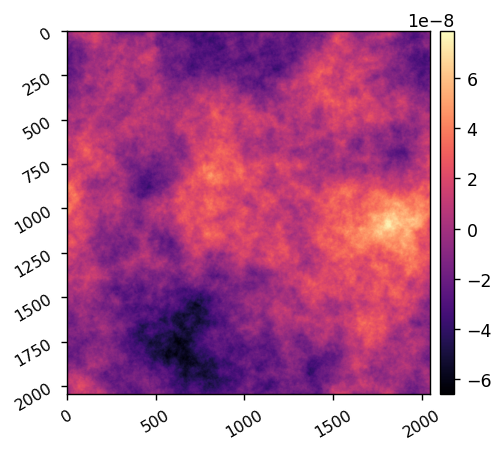

Oversampling > 2x suggested for reliable results in Fresnel propagation.


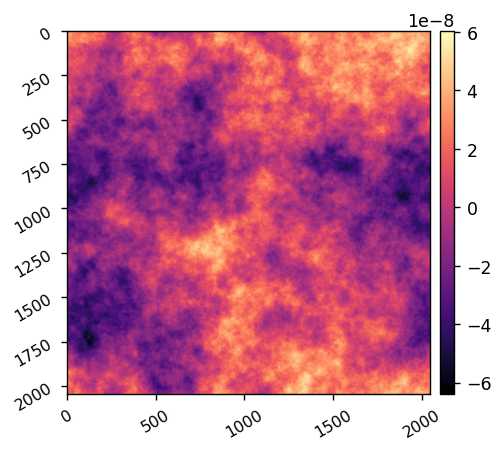

Oversampling > 2x suggested for reliable results in Fresnel propagation.


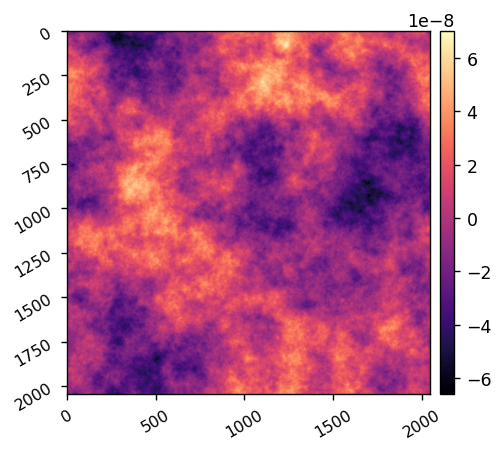

Oversampling > 2x suggested for reliable results in Fresnel propagation.


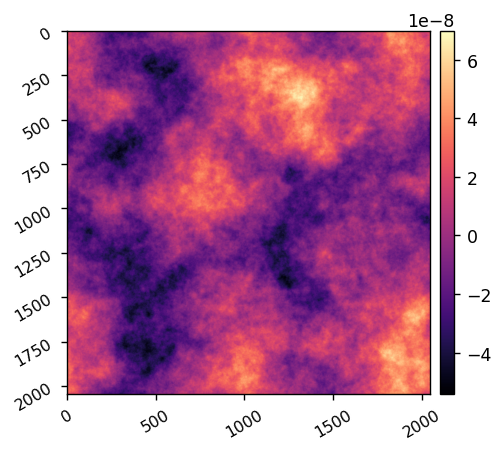

In [27]:
m1_diam = 6.5*u.m
m2_diam = 700*u.mm
m3_diam = 800*u.mm # using the maximum dimension of M3 to define the surface opd
m3_dims = [800*u.mm, 700*u.mm]

m4_diam = 100*u.mm

seeds = (1,2,3,4)

m4surf = poppy.StatisticalPSDWFE('M4 Surface OPD', index=3.0, wfe=20*u.nm, radius=m4_diam/2, seed=seeds[3])

npix = 2048 # use high-sampling when we are defining the surface errors
oversample = 1

m1surf0 = poppy.StatisticalPSDWFE('M1 Surface OPD', index=3.0, wfe=20*u.nm, radius=m1_diam/2, seed=seeds[0])
m1wf = poppy.FresnelWavefront(beam_radius=m1_diam/2, npix=npix, oversample=oversample)
m1errs = m1surf.get_opd(m1wf) # m1 
imshow1(m1errs)

m2surf0 = poppy.StatisticalPSDWFE('M2 Surface OPD', index=3.0, wfe=20*u.nm, radius=m2_diam/2, seed=seeds[1])
m2wf = poppy.FresnelWavefront(beam_radius=m2_diam/2, npix=npix, oversample=oversample)
m2errs = m2surf.get_opd(m2wf) # m1 
imshow1(m2errs)

m3surf0 = poppy.StatisticalPSDWFE('M3 Surface OPD', index=3.0, wfe=20*u.nm, radius=m3_diam/2, seed=seeds[2])
m3wf = poppy.FresnelWavefront(beam_radius=m3_diam/2, npix=npix, oversample=oversample)
m3errs = m3surf.get_opd(m3wf) # m1 
imshow1(m3errs)

m4surf0 = poppy.StatisticalPSDWFE('M4 Surface OPD', index=3.0, wfe=20*u.nm, radius=m4_diam/2, seed=seeds[3])
m4wf = poppy.FresnelWavefront(beam_radius=m4_diam/2, npix=npix, oversample=oversample)
m4errs = m4surf.get_opd(m4wf)
imshow1(m4errs)


In [25]:
m2surf.radius

<Quantity 350. mm>

# Select a pointing error sample from the data and use the ZOSAPI to calculate the shift of the beam on M2, M3, and M4. 

In [5]:
zos_path = Path('C:/Users/Kian/Projects/apra-howfsc-fpgas/zemax_models/OFFAXIS_TMA.zos')
display(zos_path)

zos = zosapi.App()
ZOSAPI = zos.ZOSAPI
TheSystem = zos.TheSystem
TheSystem.LoadFile(str(zos_path),False)

wave = TheSystem.SystemData.Wavelengths.GetWavelength(1).Wavelength * 1e-6
display(wave)



WindowsPath('C:/Users/Kian/Projects/apra-howfsc-fpgas/zemax_models/OFFAXIS_TMA.zos')

Connected to OpticStudio at: c:\program files\ansys zemax opticstudio 2023 r1.00


7.5e-07

In [18]:
# surfaces we want the ray0 data at are 3, 4, 6, and 8
LDE = TheSystem.LDE

m1_ind = 4
m2_ind = 5
m3_ind = 7
m4_ind = 9

M1 = LDE.GetSurfaceAt(3)
M2 = LDE.GetSurfaceAt(4)
M3 = LDE.GetSurfaceAt(6)
M4 = LDE.GetSurfaceAt(8)

m1_m2 = M1.Thickness
display(m1_m2)

Hx = 8.334999999999999E-002
Hy = 6.665000000000000E-002
H = np.sqrt(Hx**2 + Hy**2)

# get the real ray0 coordinates on each optic
MFE = TheSystem.MFE

m1_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m1_ind, 1, 0, 0, 0, 0, 0, 0)
m1_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m1_ind, 1, 0, 0, 0, 0, 0, 0)
m1_ray0 = np.array([m1_rx0,m1_ry0])

m2_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m2_ind, 1, 0, 0, 0, 0, 0, 0)
m2_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m2_ind, 1, 0, 0, 0, 0, 0, 0)
m2_ray0 = np.array([m2_rx0,m2_ry0])

m3_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m3_ind, 1, 0, 0, 0, 0, 0, 0)
m3_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m3_ind, 1, 0, 0, 0, 0, 0, 0)
m3_ray0 = np.array([m3_rx0,m3_ry0])

m4_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m4_ind, 1, 0, 0, 0, 0, 0, 0)
m4_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m4_ind, 1, 0, 0, 0, 0, 0, 0)
m4_ray0 = np.array([m4_rx0,m4_ry0])
print('Ray Coordinates:', m1_ray0, m2_ray0, m3_ray0, m4_ray0)

0.0

Ray Coordinates: [   0.         4030.15527516] [  0.         388.73133484] [  0.         285.00421099] [  0.         -38.10654925]


In [19]:
p = pointing.to(u.degree).value
i = 2
display(p[i])

# apply pointing error by altering the field bias
# tilt_about_x.set_Value(str(p[i][0]))
# tilt_about_y.set_Value(str(p[i][1]))

hx = p[i][0]/H
hy = p[i][1]/H

# get the real ray coordinates on each optic
m1_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m1_ind, 1, hx, hy, 0, 0, 0, 0)
m1_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m1_ind, 1, hx, hy, 0, 0, 0, 0)
m1_ray = np.array([m1_rx,m1_ry])

m2_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m2_ind, 1, hx, hy, 0, 0, 0, 0)
m2_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m2_ind, 1, hx, hy, 0, 0, 0, 0)
m2_ray = np.array([m2_rx,m2_ry])

m3_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m3_ind, 1, hx, hy, 0, 0, 0, 0)
m3_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m3_ind, 1, hx, hy, 0, 0, 0, 0)
m3_ray = np.array([m3_rx,m3_ry])

m4_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m4_ind, 1, hx, hy, 0, 0, 0, 0)
m4_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m4_ind, 1, hx, hy, 0, 0, 0, 0)
m4_ray = np.array([m4_rx,m4_ry])
print('Ray Coordinates:', m1_ray, m2_ray, m3_ray, m4_ray)

m1_shift = m1_ray0 - m1_ray
m2_shift = m2_ray0 - m2_ray
m3_shift = m3_ray0 - m3_ray
m4_shift = m4_ray0 - m4_ray
print('Shifts:', m1_shift, m2_shift, m3_shift, m4_shift)

array([7.66496459e-07, 1.91205404e-06])

Ray Coordinates: [-2.97378738e-06  4.03015527e+03] [2.24952863e-04 3.88731896e+02] [2.73231717e-03 2.85011007e+02] [-3.82182289e-06 -3.81065781e+01]
Shifts: [2.97378738e-06 7.41680697e-06] [-0.00022495 -0.0005615 ] [-0.00273232 -0.00679627] [3.82182289e-06 2.88314700e-05]


# Also use the ZOSAPI to find the low-order aberrations of the telescope optical system for perfect pointing and with the pointing error

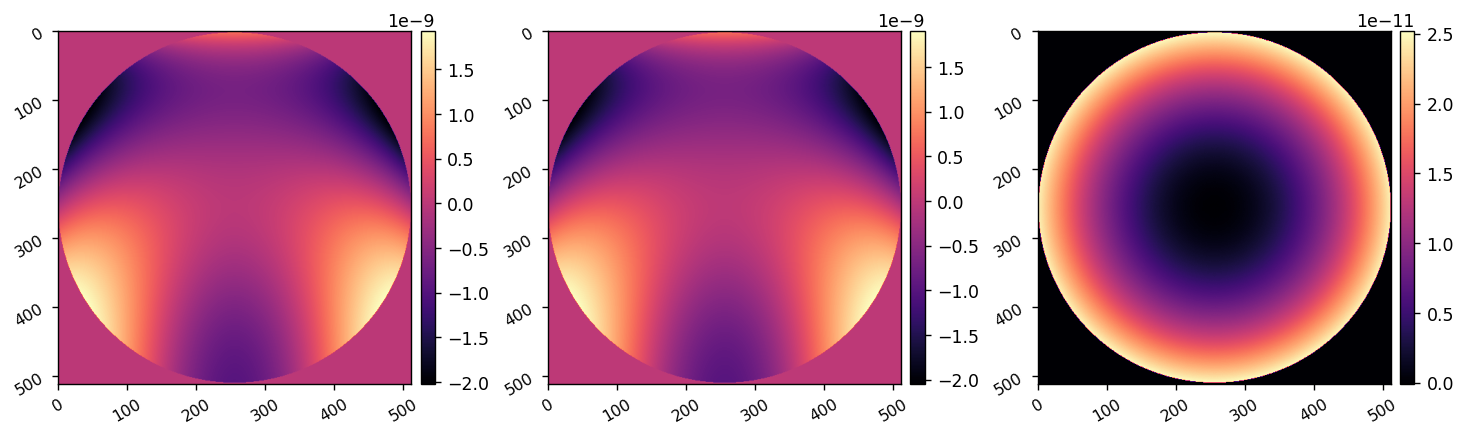

In [22]:
CB = LDE.GetSurfaceAt(3) # the coordinate break defining the system field bias
tilt_about_x = CB.GetCellAt(13)
tilt_about_y = CB.GetCellAt(14)

# Get the opd of the on-axis field
tilt_about_x.set_Value(str(0))
tilt_about_y.set_Value(str(0))

WFMap = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)
WFMapSettings = WFMap.GetSettings()
WFMapSettings.Sampling = ZOSAPI.Analysis.SampleSizes.S_1024x1024

WFMap.ApplyAndWaitForCompletion() # make sure the settings have been applied
WFMapResults = WFMap.GetResults() # get results

wfe0 = np.flip(np.array(WFMapResults.GetDataGrid(0).Values)) * wave
wfe0[np.isnan(wfe0)] = 0

tilt_about_x.set_Value(str(p[i][0]))
tilt_about_y.set_Value(str(p[i][1]))

WFMap = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)
WFMapSettings = WFMap.GetSettings()
WFMapSettings.Sampling = ZOSAPI.Analysis.SampleSizes.S_1024x1024

WFMap.ApplyAndWaitForCompletion() # make sure the settings have been applied
WFMapResults = WFMap.GetResults() # get results

wfe = np.flip(np.array(WFMapResults.GetDataGrid(0).Values)) * wave
wfe[np.isnan(wfe)] = 0

# reset the tilt of the system
tilt_about_x.set_Value(str(0))
tilt_about_y.set_Value(str(0))

imshow3(wfe0, wfe, wfe0-wfe)



# Shift the surface errors by the required amount of pixels from the calculated beam shift. 

In [43]:
def shift_surface_errors(surf_element, npix, x_shift=0*u.m, y_shift=0*u.m):
    wf = poppy.FresnelWavefront(beam_radius=surf_element.radius, npix=npix, oversample=1, wavelength=wavelength_c)
    surf_opd = surf_element.get_opd(wf)
    
    x_shift_pix = x_shift.to_value(u.m)/wf.pixelscale.to_value(u.m/u.pix)
    y_shift_pix = y_shift.to_value(u.m)/wf.pixelscale.to_value(u.m/u.pix)
    print(x_shift_pix, y_shift_pix)
    shifted_surf_opd = _scipy.ndimage.shift(surf_opd, (y_shift_pix, x_shift_pix))
    new_surf_element = poppy.ArrayOpticalElement(opd=shifted_surf_opd)
    return new_surf_element


Oversampling > 2x suggested for reliable results in Fresnel propagation.


-0.6581478038460079 -1.6427749476861206


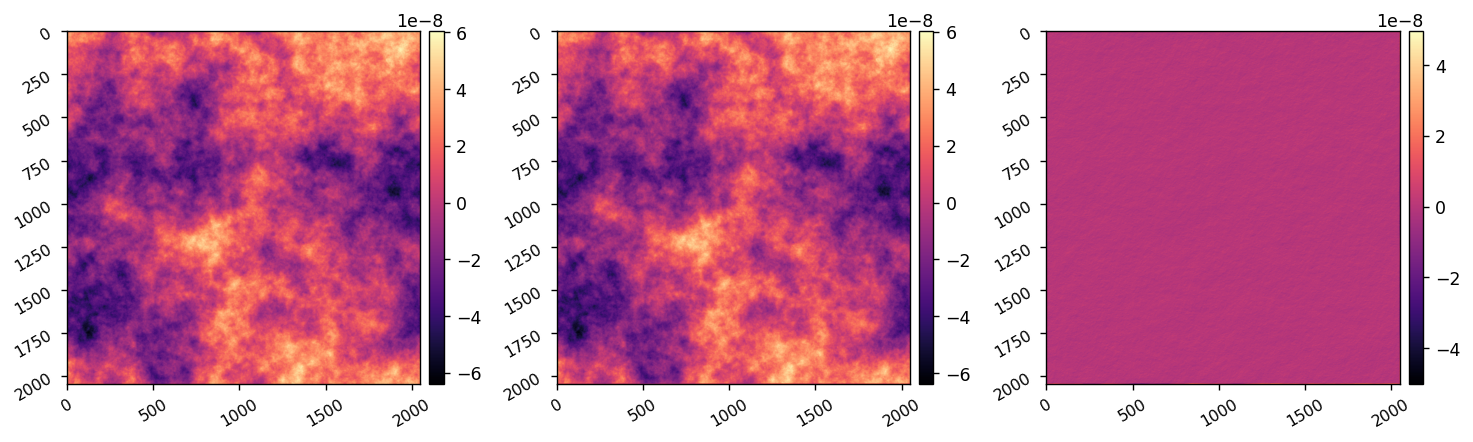

Oversampling > 2x suggested for reliable results in Fresnel propagation.


-6.994731951879134 -17.398446754086763


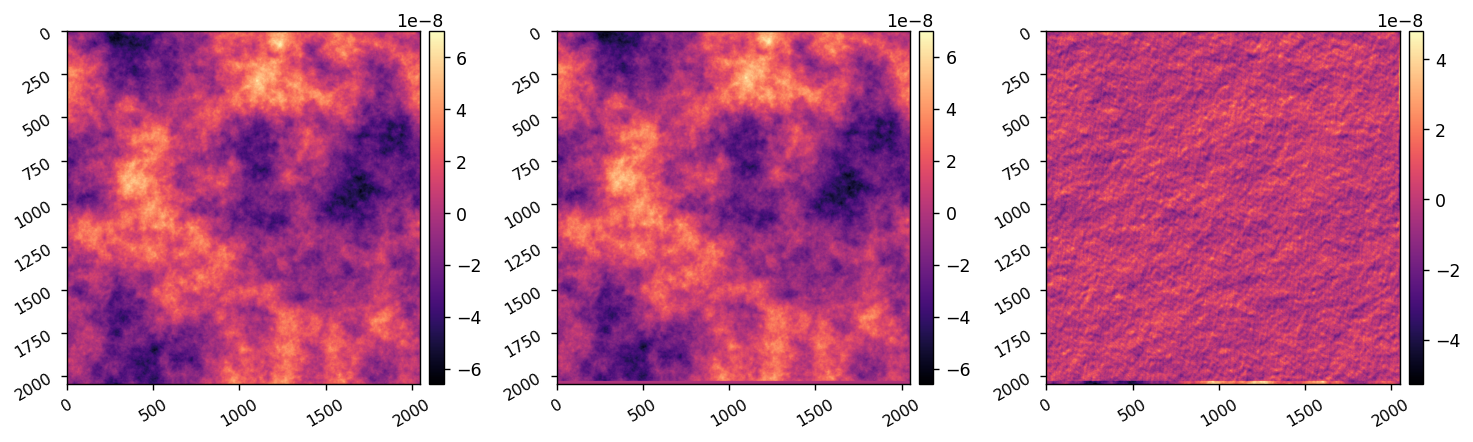

In [46]:

m2surf = shift_surface_errors(m2surf0, npix, x_shift=m2_shift[0]*u.m, y_shift=m2_shift[1]*u.m)
imshow3(m2errs, m2surf.opd, m2errs-m2surf.opd)

m3surf = shift_surface_errors(m3surf0, npix, x_shift=m3_shift[0]*u.m, y_shift=m3_shift[1]*u.m)
imshow3(m3errs, m3surf.opd, m3errs-m3surf.opd)

# Define the optical system and propagate to the exit pupil to obtain a combination of the high-order and low-order aberrations in the system. 

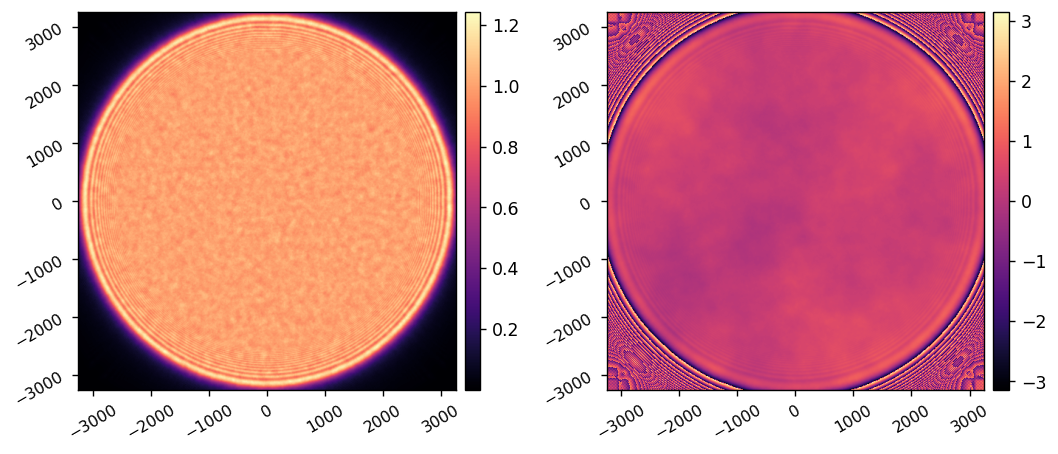

In [62]:
npix = 512
oversample = 8
pupil_diam = m1_diam
PUPIL = poppy.CircularAperture(radius=pupil_diam/2)

fl_m1 = 3.652962023674745E+004/2*u.mm
fl_m2 = -3.636649801410836E+003/2*u.mm
fl_m3 = 3.463978665836946E+003/2*u.mm

m1 = poppy.QuadraticLens(fl_m1, name='M1')
m2 = poppy.QuadraticLens(fl_m2, name='M2')
m3 = poppy.QuadraticLens(fl_m3, name='M3')
m4 = poppy.ScalarTransmission()

fosys = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix, beam_ratio=1/oversample)
fosys.add_optic(PUPIL)
fosys.add_optic(m1)
fosys.add_optic(m1surf0)
fosys.add_optic(m2, distance=1.663812910134875E+004*u.mm)
fosys.add_optic(m2surf)
fosys.add_optic(m3, distance=(16500+2000)*u.mm)
fosys.add_optic(m3surf)
fosys.add_optic(m4, distance=1.895000000000000E+003*u.mm + -5*u.mm)
fosys.add_optic(m4surf0)
fosys.add_optic(poppy.ScalarTransmission('Image'), distance=2.091997751264193E+003*u.mm + -1.75*u.mm)
fosys.add_optic(poppy.QuadraticLens(224.99998119573664*u.m), distance=224.99998119573664*u.m)
fosys.add_optic(poppy.ScalarTransmission('Image'), distance=224.99998119573664*u.m)

_, wfs = fosys.calc_psf(wavelength=750*u.nm, 
                        return_final=True, 
#                         return_intermediates=True, 
                        normalize='none')

clear_output()
# imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True, pxscl=wfs[-1].pixelscale.to_value(u.mm/u.pix))
imshow2(wfs[-1].amplitude, wfs[-1].phase, npix=npix, pxscl=wfs[-1].pixelscale.to_value(u.mm/u.pix))

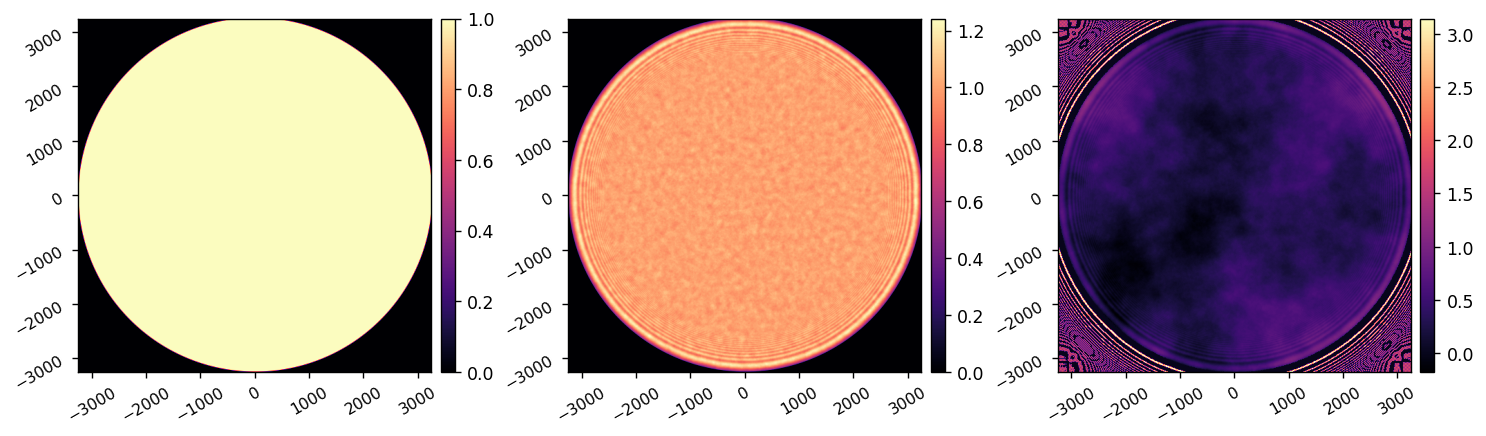

In [69]:
import misc_funs as misc
circ = misc.pad_or_crop(PUPIL.get_transmission(wfs[-1]), npix)
amp = misc.pad_or_crop(wfs[-1].amplitude, npix)
phs = misc.pad_or_crop(wfs[-1].phase, npix)
errs = amp*np.exp(1j*(phs + 2*np.pi/wavelength_c.to_value(u.m)*xp.array(wfe)))*circ

imshow3(circ, xp.abs(errs), xp.angle(errs), pxscl=wfs[-1].pixelscale.to_value(u.mm/u.pix))